In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import os

In [2]:
def load_img(img_name= ''):
    return cv2.imread(img_name, 0)

images = [load_img('man.jpg'), load_img('man2.png'), load_img('загруженное.png')]

- Входное изображение представляет собой набор из 3 пластин, соответствующих каналам B, G и R (сверху вниз).

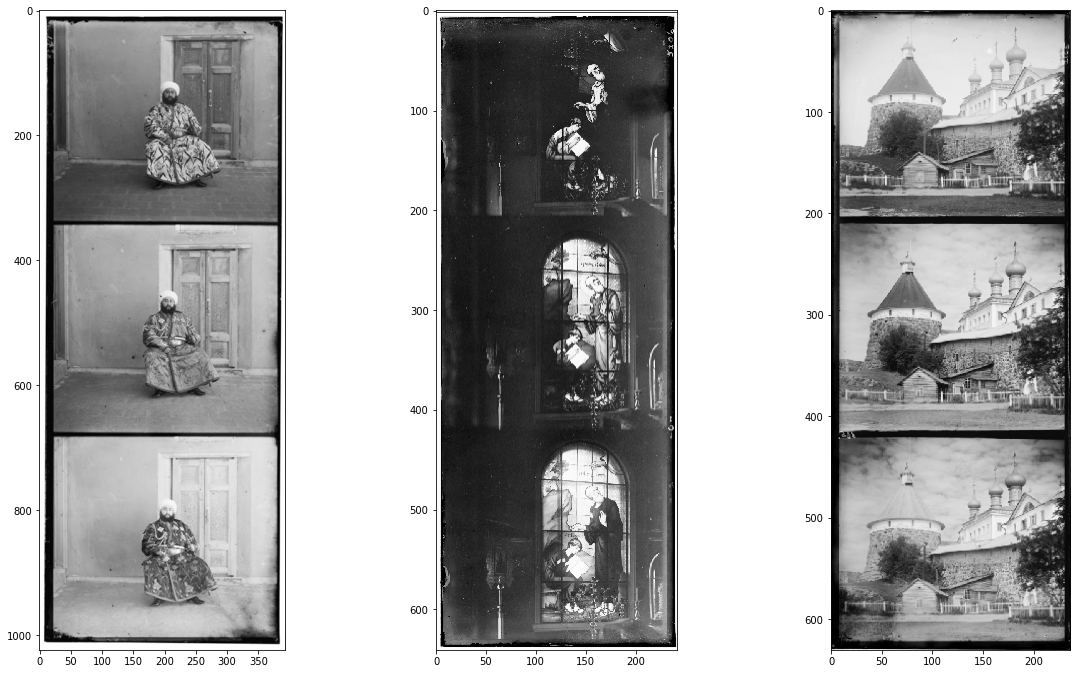

In [3]:
def visualize(imgs, format=None):
    plt.figure(figsize=(20, 40))
    for i, img in enumerate(imgs):
        if img.shape[0] == 3:
            img = img.transpose(1,2,0)
        plt_idx = i+1
        plt.subplot(3, 3, plt_idx)    
        plt.imshow(img, cmap=format)
    plt.show()

visualize(images, 'gray')

In [4]:
from  skimage.feature import canny
from skimage import dtype_limits
from scipy import ndimage
from scipy.ndimage.filters import convolve, gaussian_filter

В большинстве изображений присутствует обрамление со всех сторон. Такое обрамление может заметно ухудшить качество выравнивания каналов. Надо найти границы на пластинах с помощью детектора **Cannyedge** и обрезать изображения в соответствии с этими краями. 

Пример использования детектора Canny, реализованного в библиотеке skimage, можно найти здесь.
<br>https://scikit-image.org/docs/dev/auto_examples/edges/plot_canny.html

После применения детектора Cannyedge к изображению надо:
>Найть строки и столбцы пикселей кадра. В случае верхней границы надо искать строку в окрестности верхнего края изображения (например, 5% от его высоты). 
<br>Для каждой строки подсчитать количество краевых пикселей (полученных с помощью детектора Canny), которые она содержит.

Имея это число, надо найти среди них два максимума.
Две строки, соответствующие этим максимумам, являются краевыми строками. 
Поскольку в кадре есть два цветовых изменения (во-первых, от светлого фона сканера к темной ленте, а затем от ленты к изображению), нам нужен второй максимум, который находится дальше от границы изображения. Строка, соответствующая этому максимуму, является границей обрезки.

>Чтобы не найти два соседних пика, необходимо реализовать не-максимальное подавление: строки, расположенные рядом с первым максимумом, обнуляются, а после этого осуществляется поиск второго максимума.

Хитрый алгоритм обнаружения:

**Шумоподавление.**
>Для устранения шума изображение сглаживается гауссовским размытием с ядром размером 5×5 и σ=1.4. Поскольку сумма элементов в гауссовом ядре равна 1, ядро должно быть нормализовано до свертки.


**Вычисление градиента.**
>Когда изображение I сглаживается, вычисляются производные $I_x$ и $I_y$ со ссылкой на x и Y. Он может быть реализован путем свертки I с ядрами Kx и Ky соответственно:
Затем вычисляется величина G и наклон градиента

**Не-максимальное подавление.** 
> Для каждого пикселя находим два соседа (в положительном и отрицательном направлениях градиента, предполагая, что каждый сосед занимает угол $π/4$, и напрвлен прямо вправо). Если величина текущего пикселя больше величины соседних, то ничего не меняется, в противном случае величина текущего пикселя устанавливается равной нулю.

**Двойной порог.**
> Величины градиентов сравниваются с двумя заданными пороговыми значениями, первое из которых меньше второго. <br>Градиенты, которые меньше нижнего порогового значения, подавляются; градиенты, которые выше высокого порогового значения, помечаются как сильные, и соответствующие пиксели включаются в конечную карту ребер.
<br>Все остальные градиенты помечаются как слабые, и пиксели, соответствующие этим градиентам, рассматриваются на следующем шаге.

**Отслеживание краев с помощью гистерезиса.**
> Поскольку слабый реберный пиксель, вызванный из истинных ребер, будет соединен с сильным реберным пикселем, пиксель w со слабым градиентом помечается как ребро и включается в конечную карту ребер тогда и только тогда, когда он участвует в том же самом блобе (Связном компоненте), что и некоторый пиксель s с сильным градиентом.<br> Другими словами, должна существовать цепочка соседних слабых пикселей, соединяющих w и s (соседи составляют 8 пикселей вокруг рассматриваемого).<br> Надо составить и реализовать алгоритм, который находит все связанные компоненты градиентной карты, рассматривая каждый пиксель только один раз.<br> После этого надо решить, какие пиксели будут включены в конечную карту ребер (этот алгоритм также должен быть однопроходным).

In [5]:
def Canny_detector(img, highThreshold=91, lowThreshold=31):
    img = np.array(img, dtype=float)  # float для предотвращения отсечения значений
    
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~| шумоподавление |~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    # kernel size = int(truncate * sigma + 0.5), установка усечения (truncate) 3.3 делает ядро размера=5
    img = gaussian_filter(img, sigma=1.4, truncate=3.3)
    

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~| вычисление градиентов |~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
    Kx = [[-1,0,1],[-2,0,2],[-1,0,1]]
    Ky = [[1,2,1],[0,0,0],[-1,-2,-1]]
    Ix = convolve(img, Kx) 
    Iy = convolve(img, Ky)
    grad = np.hypot(Ix, Iy)
    theta = np.arctan2(Iy, Ix)
    thetaQ = (np.round(theta * (5.0 / np.pi)) + 5) % 5  # Направление квантования
 
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~| Не-максимальное подавление |~~~~~~~~~~~~~~~~~~~~~~~~~ #
    gradSup = grad.copy()
    for r in range(img.shape[0]):
        for c in range(img.shape[1]):
            # Подавление пикселей на краю изображения
            if r == 0 or r == img.shape[0]-1 or c == 0 or c == img.shape[1]-1:
                gradSup[r, c] = 0
                continue
            tq = thetaQ[r, c] % 4
 
            if tq == 0: # 0 is E-W (horizontal)
                if grad[r, c] <= grad[r, c-1] or grad[r, c] <= grad[r, c+1]:
                    gradSup[r, c] = 0
            if tq == 1: # 1 is NE-SW
                if grad[r, c] <= grad[r-1, c+1] or grad[r, c] <= grad[r+1, c-1]:
                    gradSup[r, c] = 0
            if tq == 2: # 2 is N-S (vertical)
                if grad[r, c] <= grad[r-1, c] or grad[r, c] <= grad[r+1, c]:
                    gradSup[r, c] = 0
            if tq == 3: # 3 is NW-SE
                if grad[r, c] <= grad[r-1, c-1] or grad[r, c] <= grad[r+1, c+1]:
                    gradSup[r, c] = 0
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~| Двойной порог |~~~~~~~~~~~~~~~~~~~~~~~~~ #
    strongEdges = (gradSup > highThreshold) 
    # Сильный имеет значение 2, слабый имеет значение 1
    thresholdedEdges = np.array(strongEdges, dtype=np.uint8) + (gradSup > lowThreshold)
 
   # ~~~~~~~~~~~~~~| Отслеживание кромок с помощью гистерезиса |~~~~~~~~~~~~#
    # Найти слабые граничные пиксели рядом с сильными граничными пикселями
    finalEdges = strongEdges.copy()
    currentPixels = []
    for r in range(1, img.shape[0]-1):
        for c in range(1, img.shape[1]-1):
            if thresholdedEdges[r, c] != 1:
                continue # Ни одного слабого пикселя
 
            # get 3x3 patch
            localPatch = thresholdedEdges[r-1:r+2,c-1:c+2]
            patchMax = localPatch.max()
            if patchMax == 2:
                currentPixels.append((r, c))
                finalEdges[r, c] = 1
 
    # Расширение сильных ребер на основе текущих пикселей
    while len(currentPixels) > 0:
        newPix = []
        for r, c in currentPixels:
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    if dr == 0 and dc == 0: continue
                    r2 = r+dr
                    c2 = c+dc
                    if thresholdedEdges[r2, c2] == 1 and finalEdges[r2, c2] == 0:
                        # копирование слабого пикселя в конечный результат
                        newPix.append((r2, c2))
                        finalEdges[r2, c2] = 1
        currentPixels = newPix
    return finalEdges

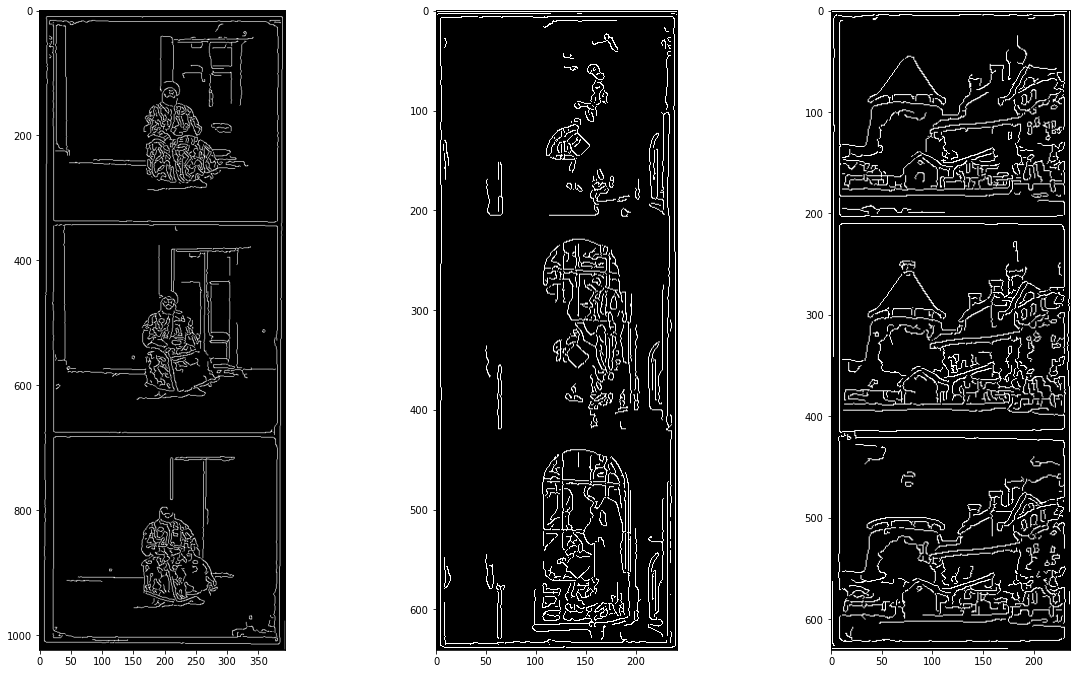

In [6]:
canny_imgs = []
for img in images:
    canny_img = Canny_detector(img)
    canny_imgs.append(canny_img)
    
visualize(canny_imgs, 'gray')

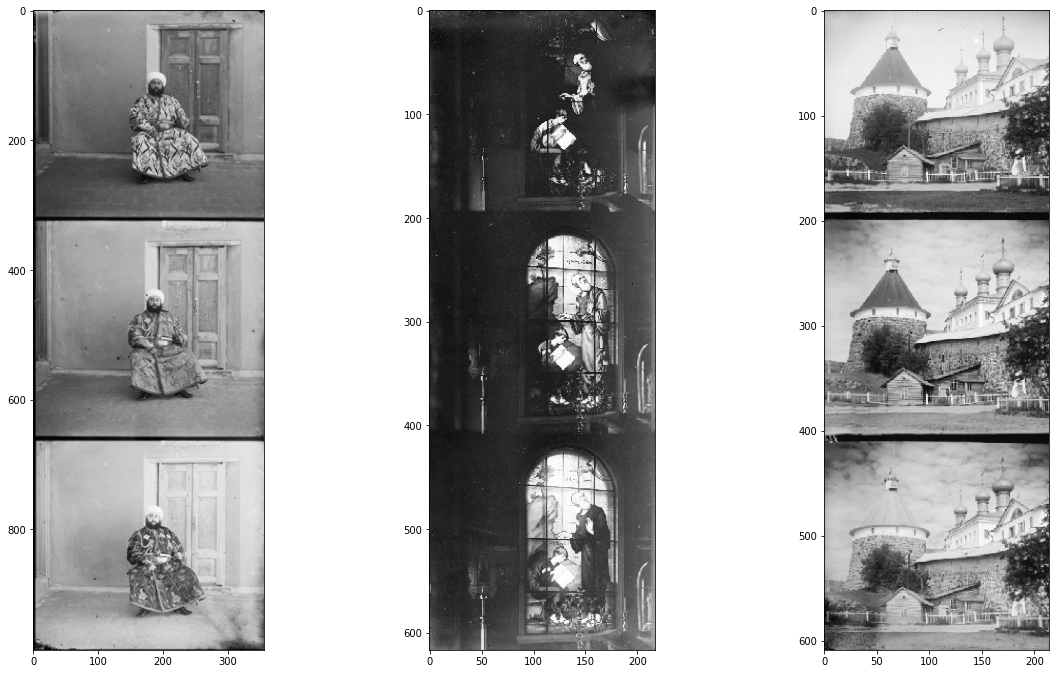

In [7]:
def remove_borders(img, canny_img):
    """ Your implementation instead of the following one"""   
    dx = int(img.shape[1] * 0.05) 
    return img[dx : -dx, dx : -dx]


cropped_imgs = []
for i, img in enumerate(images):
    cropped_imgs.append(remove_borders(img, canny_imgs[i]))

visualize(cropped_imgs, 'gray')

Нужно разделить изображение на три канала **(B, G, R)** и сделать одно цветное изображение. 
>Чтобы получить каналы, можно разделить каждую пластину на три равные части.

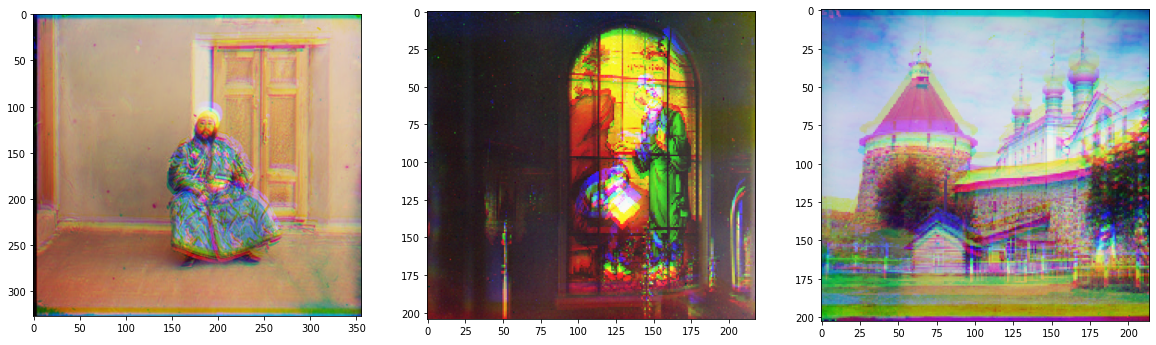

In [8]:
def impose_components(img):
    height = img.shape[0] // 3
    merged = np.zeros((height, img.shape[1], 3), dtype=np.int32)
    merged[..., 0] = img[-height:, :]         # R
    merged[..., 1] = img[height: height*2, :] # G
    merged[..., 2] = img[0:height, :]         # B
    return merged

rgb_imgs = []
for cropped_img in cropped_imgs:
    rgb_img = impose_components(cropped_img)
    rgb_imgs.append(rgb_img)

visualize(rgb_imgs)

### Поиск наилучшего сдвига для выравнивания каналов.
Чтобы выровнять два изображения, надо сдвигать одно изображение относительно другого в некоторых пределах (например, от $-15$ до $15$ пикселей).

Для каждого сдвига надо рассчитать некоторые метрики в перекрытии изображений.
>В зависимости от метрик лучшим сдвигом является тот, для которого метрика достигает наибольшего или наименьшего значения. Есть две метрики, которые позволяют получить лучшее качество выравнивания:

Mean squared error (MSE):
$$ MSE(I_1, I_2) = \dfrac{1}{w * h}\sum_{x,y}(I_1(x,y)-I_2(x,y))^2, $$
Normalized cross-correlation (CC):
$$ I_1 \ast I_2 = \dfrac{\sum_{x,y}I_1(x,y)I_2(x,y)}{\sum_{x,y}I_1(x,y)\sum_{x,y}I_2(x,y)}. $$
>w, h-ширина и высота изображений соответственно. Чтобы найти оптимальный сдвиг, надо найти минимальный MSE по всем значениям сдвига.



In [9]:
def mse(X, Y):
    return np.mean((X - Y)**2)
    

def cor(X, Y):
    return np.sum(X*Y) / (np.sum(X) * np.sum(Y))

In [10]:

def get_best_shift(channel1, channel2, metric):
    candidates = [(dy, metric(channel1, ndimage.shift(channel2, shift=[dy, 0]))) for dy in range(-15, 16)]
    best_shift = sorted(candidates, key=lambda x: x[1])[0][0]
    return best_shift


def get_best_image(rgb_img, metric):
    final_img = np.zeros(rgb_img.shape, dtype=np.int32)
    final_img[..., 0] = rgb_img[..., 0]
    shift1 = get_best_shift(rgb_img[..., 0], rgb_img[..., 1], metric)
    final_img[..., 1] = ndimage.shift(rgb_img[..., 1], shift=[shift1, 0])
    shift2 = get_best_shift(rgb_img[..., 0], rgb_img[..., 2], metric)
    final_img[..., 2] = ndimage.shift(rgb_img[..., 2], shift=[shift2, 0])
    return final_img



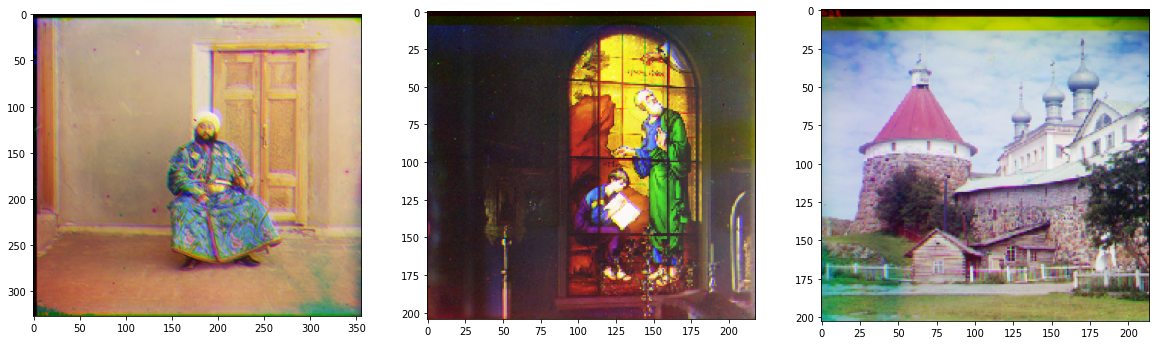

In [20]:
final_imgs = []
for img in rgb_imgs:
    final_img = get_best_image(img, mse)
    final_imgs.append(final_img)

visualize(final_imgs)